<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S12_TinyImageNet_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-04-19 04:19:46.073230


In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/tiny-imagenet-200.zip"
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data  tiny-imagenet-200


In [3]:
# Copying the code from github to drive
%cd gdrive/My Drive/project_folder
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
! ls

/content/gdrive/My Drive/project_folder
Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1586 (delta 6), reused 0 (delta 0), pack-reused 1571
Receiving objects: 100% (1586/1586), 16.53 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (966/966), done.
Checking out files: 100% (123/123), done.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S12_TinyImageNet_ResNet
models	README.md  S12_TinyImageNet_ResNet.ipynb


In [4]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)  

****apex module does not exist..hence installing*****
  Cloning https://www.github.com/NVIDIA/apex to /tmp/pip-req-build-hs0ul5hb
  Running command git clone -q https://www.github.com/NVIDIA/apex /tmp/pip-req-build-hs0ul5hb
  Running command git submodule update --init --recursive -q
  Created wheel for apex: filename=apex-0.1-cp36-none-any.whl size=153287 sha256=a8c4688208a2a6d6c33acbbe2d242592355de8c287e4701385c9cd88e3c09fed
  Stored in directory: /tmp/pip-ephem-wheel-cache-q85zw36c/wheels/08/3e/36/a75a9914e497fe42598f9dbe67496b2b300a8851f4d396a285
Successfully built apex
0.1.12
     |████████████████████████████████| 122kB 8.8MB/s 
     |████████████████████████████████| 634kB 14.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=2aab94edadba7957e6452a56c94f96e9eb4bb672fc312220f974dc730daca441
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug:

Pytorch version: 1.4.0


In [0]:
from models import Alb_data_transforms,Resnet18_TinyImageNet,S1_S11_models,Train_Losses,Test_losses
import models.dataset.dataloader as dl
import models.dataset.dataset as ds
import models.utils.Utils as utils
from models.dataset.tinyimagenethelper import TinyImagenetHelper
from models.dataset.tinyimagenetdataset import TinyImagenetDataset
import models.visualization.plotdata as plotdata

In [6]:
helper = TinyImagenetHelper()
path = '/content/tiny-imagenet-200/'
dict = helper.get_id_dictionary(path=path)
values, classes = helper.get_class_to_id_dict(id_dict=dict, path=path)
train_data, train_label, test_data, test_label = helper.get_train_test_labels_data(dict, path)

100%|██████████| 200/200 [00:00<00:00, 2443.83it/s]
10000it [00:00, 555404.54it/s]

Starting data loading
Finished data loading, in 0.10646891593933105 seconds


In [0]:
import albumentations as A
tiny_image_net_mean = [0.485, 0.456, 0.406]
tiny_image_net_std  = [0.229, 0.224, 0.225] 
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=tiny_image_net_mean, std=tiny_image_net_std)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=tiny_image_net_mean, std=tiny_image_net_std),
                                                                  A.Cutout(num_holes=1,max_h_size=16,max_w_size=16), 
                                                                  # Using default fillvalue=0 for cutout because after normalizing mean is 0
                                                                  # Size used for cutout as 8 i.e. 25% of 32x32 CIFAR 10 data                                                                 
                                                                 ])

In [0]:
train_dataset = TinyImagenetDataset(image_data=train_data, image_labels=train_label,transform=train_transforms)
test_dataset  = TinyImagenetDataset(image_data=test_data, image_labels=test_label,transform=test_transforms)

In [9]:
batch_size = 256
data_loader = dl.Dataloader(traindataset=train_dataset, testdataset=test_dataset, batch_size=batch_size)
train_loader = data_loader.gettraindataloader()
test_loader = data_loader.gettestdataloader()

CUDA Available? True
256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

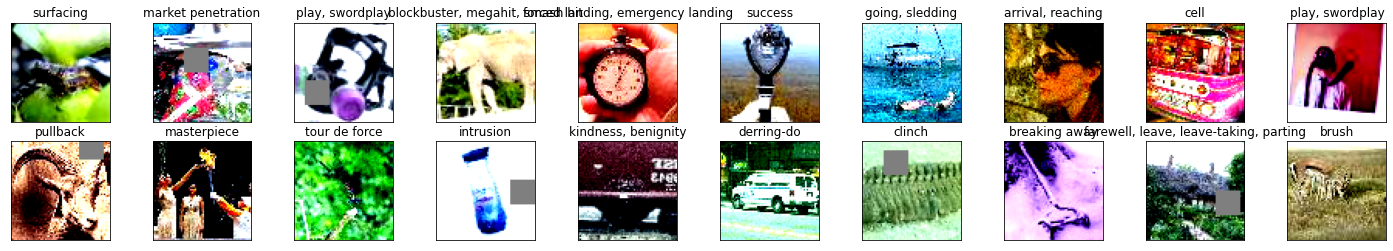

In [10]:
data_iterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(data_iterator, classes=classes)

In [0]:
#import os
#os.chdir('/content/gdrive/My Drive')

In [11]:
!pip install torchsummary
from torchsummary import summary
model = Resnet18_TinyImageNet.ResNet_18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

# Train and Test the model using ReduceLROnPlateau

**ReduceLROnPlateau-**Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced by 'factor' supplied. 

mode = 'min' means lr will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing.

'min_lr' -> A lower bound on the LR upto which it can be reduced

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 50
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.03

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []

OPTIMIZER = optim.SGD(model.parameters(), lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', factor = 0.1, min_lr=1e-7, patience = 4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):

    print("\nEPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,criterion=criterion,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct = \
                              test_loss.test_loss_calc(model,model.device,test_loader=test_loader, optimizer=OPTIMIZER, total_epoch=EPOCH, 
                                                       current_epoch = epoch,criterion=criterion,scheduler=SCHEDULER)                  
        
    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

    if len(test_loss_all) > 1:
       loss_decrease = 0                  
       loss_decrease = test_loss_all[-2] - test_loss_all[-1]                             
       if loss_decrease > 0:
          print('Test Loss -> Decreasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))     
       else: 
          print('Test Loss -> Increasing, Prev Loss: {:.6f}, Latest Loss: {:.6f}, Delta: {:.6f}' .format(test_loss_all[-2], test_loss_all[-1], loss_decrease))  

  0%|          | 0/301 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 3.4288501739501953 Batch Id = 300 Train Acc = 21.50 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Test Accuracy: 22.63, LR : 0.030000

EPOCH: 1


Train Loss = 2.989084243774414 Batch Id = 300 Train Acc = 27.07 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Test Accuracy: 24.88, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.013332, Latest Loss: 0.013223, Delta: 0.000109

EPOCH: 2


Train Loss = 2.653982639312744 Batch Id = 300 Train Acc = 31.64 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Test Accuracy: 28.87, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.013223, Latest Loss: 0.011977, Delta: 0.001247

EPOCH: 3


Train Loss = 2.514220714569092 Batch Id = 300 Train Acc = 35.84 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Test Accuracy: 33.16, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.011977, Latest Loss: 0.011221, Delta: 0.000756

EPOCH: 4


Train Loss = 2.502185106277466 Batch Id = 300 Train Acc = 39.09 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Test Accuracy: 34.09, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.011221, Latest Loss: 0.011185, Delta: 0.000036

EPOCH: 5


Train Loss = 2.3486428260803223 Batch Id = 300 Train Acc = 42.15 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Test Accuracy: 35.64, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.011185, Latest Loss: 0.010813, Delta: 0.000372

EPOCH: 6


Train Loss = 2.1547136306762695 Batch Id = 300 Train Acc = 44.41 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Test Accuracy: 35.08, LR : 0.030000
Test Loss -> Increasing, Prev Loss: 0.010813, Latest Loss: 0.011094, Delta: -0.000281

EPOCH: 7


Train Loss = 2.1856305599212646 Batch Id = 300 Train Acc = 47.36 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Test Accuracy: 42.59, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.011094, Latest Loss: 0.009418, Delta: 0.001676

EPOCH: 8


Train Loss = 1.96193528175354 Batch Id = 300 Train Acc = 49.48 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Test Accuracy: 40.78, LR : 0.030000
Test Loss -> Increasing, Prev Loss: 0.009418, Latest Loss: 0.009991, Delta: -0.000573

EPOCH: 9


Train Loss = 2.011526346206665 Batch Id = 300 Train Acc = 51.68 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Test Accuracy: 44.52, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.009991, Latest Loss: 0.009107, Delta: 0.000884

EPOCH: 10


Train Loss = 1.8345977067947388 Batch Id = 300 Train Acc = 53.51 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Test Accuracy: 41.59, LR : 0.030000
Test Loss -> Increasing, Prev Loss: 0.009107, Latest Loss: 0.009838, Delta: -0.000731

EPOCH: 11


Train Loss = 1.8685760498046875 Batch Id = 300 Train Acc = 55.25 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Test Accuracy: 46.68, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.009838, Latest Loss: 0.008668, Delta: 0.001170

EPOCH: 12


Train Loss = 1.9221909046173096 Batch Id = 300 Train Acc = 57.55 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Test Accuracy: 44.62, LR : 0.030000
Test Loss -> Increasing, Prev Loss: 0.008668, Latest Loss: 0.009279, Delta: -0.000611

EPOCH: 13


Train Loss = 1.6181832551956177 Batch Id = 300 Train Acc = 59.33 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Test Accuracy: 44.25, LR : 0.030000
Test Loss -> Increasing, Prev Loss: 0.009279, Latest Loss: 0.009377, Delta: -0.000099

EPOCH: 14


Train Loss = 1.7177181243896484 Batch Id = 300 Train Acc = 61.04 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Test Accuracy: 46.50, LR : 0.030000
Test Loss -> Decreasing, Prev Loss: 0.009377, Latest Loss: 0.008977, Delta: 0.000400

EPOCH: 15


Train Loss = 1.4629350900650024 Batch Id = 300 Train Acc = 62.72 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Test Accuracy: 44.72, LR : 0.030000
Test Loss -> Increasing, Prev Loss: 0.008977, Latest Loss: 0.009458, Delta: -0.000481

EPOCH: 16


Train Loss = 1.2219876050949097 Batch Id = 300 Train Acc = 64.33 LR =0.030000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    17: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.0095, Test Accuracy: 45.03, LR : 0.003000
Test Loss -> Increasing, Prev Loss: 0.009458, Latest Loss: 0.009524, Delta: -0.000067

EPOCH: 17


Train Loss = 0.9469863176345825 Batch Id = 300 Train Acc = 74.59 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Test Accuracy: 56.25, LR : 0.003000
Test Loss -> Decreasing, Prev Loss: 0.009524, Latest Loss: 0.007053, Delta: 0.002471

EPOCH: 18


Train Loss = 1.0340174436569214 Batch Id = 300 Train Acc = 77.76 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.44, LR : 0.003000
Test Loss -> Decreasing, Prev Loss: 0.007053, Latest Loss: 0.007016, Delta: 0.000037

EPOCH: 19


Train Loss = 0.8000628352165222 Batch Id = 300 Train Acc = 78.90 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Test Accuracy: 56.34, LR : 0.003000
Test Loss -> Increasing, Prev Loss: 0.007016, Latest Loss: 0.007065, Delta: -0.000049

EPOCH: 20


Train Loss = 0.9458349943161011 Batch Id = 300 Train Acc = 79.78 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Test Accuracy: 56.67, LR : 0.003000
Test Loss -> Decreasing, Prev Loss: 0.007065, Latest Loss: 0.007051, Delta: 0.000014

EPOCH: 21


Train Loss = 0.5812321305274963 Batch Id = 300 Train Acc = 80.71 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Test Accuracy: 56.58, LR : 0.003000
Test Loss -> Increasing, Prev Loss: 0.007051, Latest Loss: 0.007068, Delta: -0.000017

EPOCH: 22


Train Loss = 0.7481957674026489 Batch Id = 300 Train Acc = 81.13 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Test Accuracy: 56.54, LR : 0.003000
Test Loss -> Increasing, Prev Loss: 0.007068, Latest Loss: 0.007076, Delta: -0.000007

EPOCH: 23


Train Loss = 0.788884162902832 Batch Id = 300 Train Acc = 81.85 LR =0.003000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    24: reducing learning rate of group 0 to 3.0000e-04.

Test set: Average loss: 0.0071, Test Accuracy: 56.49, LR : 0.000300
Test Loss -> Increasing, Prev Loss: 0.007076, Latest Loss: 0.007106, Delta: -0.000030

EPOCH: 24


Train Loss = 0.7330588102340698 Batch Id = 300 Train Acc = 83.26 LR =0.000300: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.93, LR : 0.000300
Test Loss -> Decreasing, Prev Loss: 0.007106, Latest Loss: 0.007033, Delta: 0.000073

EPOCH: 25


Train Loss = 0.6668301820755005 Batch Id = 300 Train Acc = 83.58 LR =0.000300: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.98, LR : 0.000300
Test Loss -> Increasing, Prev Loss: 0.007033, Latest Loss: 0.007035, Delta: -0.000002

EPOCH: 26


Train Loss = 0.5587900280952454 Batch Id = 300 Train Acc = 83.84 LR =0.000300: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.86, LR : 0.000300
Test Loss -> Increasing, Prev Loss: 0.007035, Latest Loss: 0.007037, Delta: -0.000003

EPOCH: 27


Train Loss = 0.7097638249397278 Batch Id = 300 Train Acc = 83.88 LR =0.000300: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.99, LR : 0.000300
Test Loss -> Increasing, Prev Loss: 0.007037, Latest Loss: 0.007040, Delta: -0.000003

EPOCH: 28


Train Loss = 0.5868991613388062 Batch Id = 300 Train Acc = 83.89 LR =0.000300: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    29: reducing learning rate of group 0 to 3.0000e-05.

Test set: Average loss: 0.0070, Test Accuracy: 56.95, LR : 0.000030
Test Loss -> Decreasing, Prev Loss: 0.007040, Latest Loss: 0.007039, Delta: 0.000001

EPOCH: 29


Train Loss = 0.5857415199279785 Batch Id = 300 Train Acc = 84.12 LR =0.000030: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.97, LR : 0.000030
Test Loss -> Decreasing, Prev Loss: 0.007039, Latest Loss: 0.007037, Delta: 0.000002

EPOCH: 30


Train Loss = 0.7919223308563232 Batch Id = 300 Train Acc = 84.09 LR =0.000030: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.98, LR : 0.000030
Test Loss -> Decreasing, Prev Loss: 0.007037, Latest Loss: 0.007036, Delta: 0.000001

EPOCH: 31


Train Loss = 0.5457723140716553 Batch Id = 300 Train Acc = 84.11 LR =0.000030: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 57.01, LR : 0.000030
Test Loss -> Decreasing, Prev Loss: 0.007036, Latest Loss: 0.007032, Delta: 0.000004

EPOCH: 32


Train Loss = 0.7066571712493896 Batch Id = 300 Train Acc = 84.25 LR =0.000030: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 57.00, LR : 0.000030
Test Loss -> Decreasing, Prev Loss: 0.007032, Latest Loss: 0.007030, Delta: 0.000002

EPOCH: 33


Train Loss = 0.6536266803741455 Batch Id = 300 Train Acc = 84.17 LR =0.000030: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    34: reducing learning rate of group 0 to 3.0000e-06.

Test set: Average loss: 0.0070, Test Accuracy: 56.93, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.007030, Latest Loss: 0.007032, Delta: -0.000002

EPOCH: 34


Train Loss = 0.6706181168556213 Batch Id = 300 Train Acc = 84.12 LR =0.000003: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.98, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.007032, Latest Loss: 0.007031, Delta: 0.000001

EPOCH: 35


Train Loss = 0.6189727187156677 Batch Id = 300 Train Acc = 84.09 LR =0.000003: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.99, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.007031, Latest Loss: 0.007031, Delta: -0.000000

EPOCH: 36


Train Loss = 0.6683917045593262 Batch Id = 300 Train Acc = 84.07 LR =0.000003: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 57.04, LR : 0.000003
Test Loss -> Decreasing, Prev Loss: 0.007031, Latest Loss: 0.007030, Delta: 0.000001

EPOCH: 37


Train Loss = 0.7852222919464111 Batch Id = 300 Train Acc = 84.14 LR =0.000003: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.99, LR : 0.000003
Test Loss -> Increasing, Prev Loss: 0.007030, Latest Loss: 0.007038, Delta: -0.000008

EPOCH: 38


Train Loss = 0.672015368938446 Batch Id = 300 Train Acc = 84.41 LR =0.000003: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    39: reducing learning rate of group 0 to 3.0000e-07.

Test set: Average loss: 0.0070, Test Accuracy: 56.95, LR : 0.000000
Test Loss -> Decreasing, Prev Loss: 0.007038, Latest Loss: 0.007033, Delta: 0.000005

EPOCH: 39


Train Loss = 0.6082610487937927 Batch Id = 300 Train Acc = 84.13 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.95, LR : 0.000000
Test Loss -> Decreasing, Prev Loss: 0.007033, Latest Loss: 0.007029, Delta: 0.000004

EPOCH: 40


Train Loss = 0.7408749461174011 Batch Id = 300 Train Acc = 84.25 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 57.02, LR : 0.000000
Test Loss -> Increasing, Prev Loss: 0.007029, Latest Loss: 0.007030, Delta: -0.000002

EPOCH: 41


Train Loss = 0.6384882926940918 Batch Id = 300 Train Acc = 84.31 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 57.04, LR : 0.000000
Test Loss -> Increasing, Prev Loss: 0.007030, Latest Loss: 0.007033, Delta: -0.000003

EPOCH: 42


Train Loss = 0.8174059987068176 Batch Id = 300 Train Acc = 84.28 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.98, LR : 0.000000
Test Loss -> Decreasing, Prev Loss: 0.007033, Latest Loss: 0.007031, Delta: 0.000002

EPOCH: 43


Train Loss = 0.665485143661499 Batch Id = 300 Train Acc = 84.26 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]

Epoch    44: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.0070, Test Accuracy: 56.99, LR : 0.000000
Test Loss -> Increasing, Prev Loss: 0.007031, Latest Loss: 0.007041, Delta: -0.000010

EPOCH: 44


Train Loss = 0.794065535068512 Batch Id = 300 Train Acc = 84.05 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.97, LR : 0.000000
Test Loss -> Decreasing, Prev Loss: 0.007041, Latest Loss: 0.007030, Delta: 0.000011

EPOCH: 45


Train Loss = 0.6487256288528442 Batch Id = 300 Train Acc = 84.22 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 57.04, LR : 0.000000
Test Loss -> Increasing, Prev Loss: 0.007030, Latest Loss: 0.007038, Delta: -0.000007

EPOCH: 46


Train Loss = 0.7549005746841431 Batch Id = 300 Train Acc = 84.24 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.95, LR : 0.000000
Test Loss -> Decreasing, Prev Loss: 0.007038, Latest Loss: 0.007032, Delta: 0.000005

EPOCH: 47


Train Loss = 0.8219814896583557 Batch Id = 300 Train Acc = 84.32 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.98, LR : 0.000000
Test Loss -> Increasing, Prev Loss: 0.007032, Latest Loss: 0.007033, Delta: -0.000000

EPOCH: 48


Train Loss = 0.8393416404724121 Batch Id = 300 Train Acc = 84.25 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.86it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Test Accuracy: 56.94, LR : 0.000000
Test Loss -> Decreasing, Prev Loss: 0.007033, Latest Loss: 0.007032, Delta: 0.000001

EPOCH: 49


Train Loss = 0.7022427916526794 Batch Id = 300 Train Acc = 84.25 LR =0.000000: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]



Test set: Average loss: 0.0070, Test Accuracy: 56.94, LR : 0.000000
Test Loss -> Increasing, Prev Loss: 0.007032, Latest Loss: 0.007038, Delta: -0.000006


#### Below section of code is to plot **validation accuracy, test loss, training accuracy and train loss** for the all the epochs trained

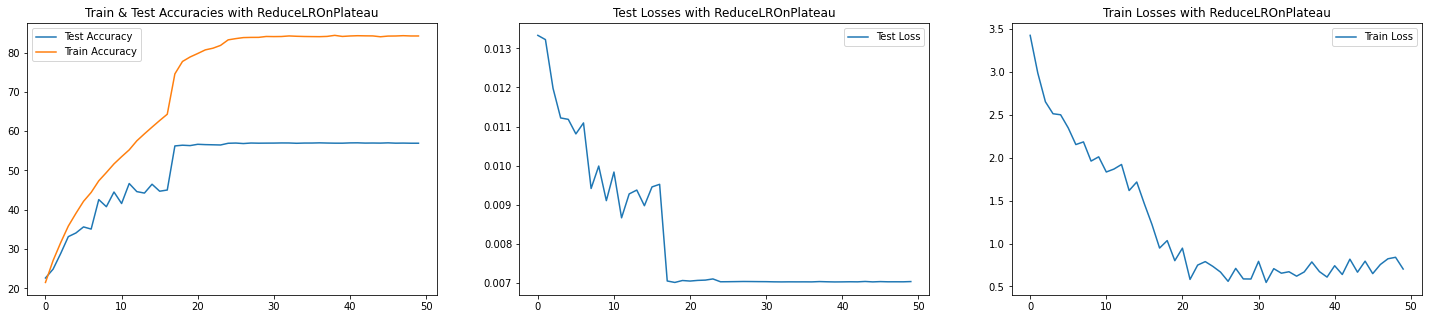

In [15]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")   